# Denoising Pipeline Development

In [2]:
%load_ext autoreload
%autoreload 2

import fibsem
# import pepper
# from pepper.salami import run_salami, SalamiSettings
from fibsem import utils, acquire, alignment, calibration, milling
from fibsem.structures import BeamType, FibsemPatternSettings, FibsemMillingSettings, FibsemPattern
import matplotlib.pyplot as plt
import numpy as np
import os

import logging



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Automation (TESCAN) not installed.
Autoscript (ThermoFisher) not installed.


In [3]:
microscope, settings = utils.setup_session()


2023-02-27 17:50:40,477 — root — INFO — connect_to_microscope:2141 — Connected to Demo Microscope
2023-02-27 17:50:40,479 — root — INFO — setup_session:218 — Finished setup for session: demo_2023-02-27-05-50-40PM


2023-02-27 17:50:40,778 — root — INFO — autocontrast:2167 — Autocontrast: BeamType.ELECTRON
2023-02-27 17:50:40,791 — root — INFO — autocontrast:2167 — Autocontrast: BeamType.ION


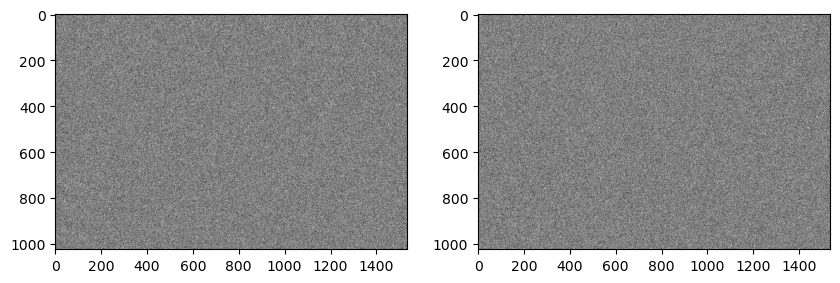

In [4]:
eb_image, ib_image = acquire.take_reference_images(microscope, settings.image)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(eb_image.data, cmap="gray")
ax[1].imshow(ib_image.data, cmap="gray")
plt.show()


## Parameter Sweep

- Set a list of parameters to sweep through
- Acquire images using the sweep parameters
- Run the denoising pipeline on the images
- Save the results
- Fit the curve, and show results to user

In [ ]:
# pixelsize (nm), # pixelsize = hfw/n_pixels_x
pixelsizes = np.array([1, 2, 3, 4, 5, 6, 8, 10])#, 12, 14, 16, 18, 20])
resolutions = [[1536, 1024], [3072, 2048]]#, [6144, 4096]]
voltages = [1e3, 2e3]
currents = [1.6e-9, 0.1e-9, 0.2e-9]#, 0.4e-9, 0.8e-9] 
dwell_times = [0.5e-6, 1e-6, 3e-6]#, 5e-6, 8e-6, 20e-6]

import pandas as pd
base_path = os.path.join(settings.image.save_path, "data")

df = pd.DataFrame(columns=["voltage", "current", "resolution_x", "resolution_y", "hfw", "dwell_time"])
parameters = []
for voltage in voltages:
    for current in currents:
        for resolution in resolutions:
            hfws = pixelsizes * resolution[0] * 1e-9 # nm
            for hfw in hfws:
                for dwell_time in dwell_times:
                
                    idx = len(parameters)
                    idx = f"{idx:04d}"
                    data_path = os.path.join(base_path, idx)
                    os.makedirs(data_path, exist_ok=True)

                    params = {"voltage": voltage, "current": current, 
                            "resolution_x": resolution[0], "resolution_y": resolution[1], 
                            "hfw": hfw, "dwell_time": dwell_time,
                            "idx": idx, "path": data_path}
                    parameters.append(params)

print(len(parameters))
df = pd.DataFrame(parameters)
display(df)
df.to_csv(os.path.join(base_path, "parameters.csv"), index=False)

In [ ]:
df = pd.read_csv(os.path.join(base_path, "parameters.csv"))
display(df)


params_dict = df.to_dict("records")

In [ ]:


# image settings
settings.image.save = True
settings.image.autocontrast = False
settings.image.gamma_enabled = False

# milling settings
start_x, end_x = -8e-6, 33e-6
start_y, end_y = -4e-6, -4e-6
depth = 8e-6

pattern_settings = FibsemPatternSettings(pattern=FibsemPattern.Line, start_x=start_x, start_y=start_y, end_x=end_x, end_y=end_y, depth=depth)
milling_settings = FibsemMillingSettings(milling_current=5.6e-9, hfw=150e-6)

# salami settings
ss = SalamiSettings(n_steps=5, step_size=5e-9)

# sweep through all params, collect data
for i, parameters in enumerate(params_dict):

    voltage = float(parameters["voltage"])
    current = float(parameters["current"])
    resolution = [int(parameters["resolution_x"]), int(parameters["resolution_y"])]
    hfw = float(parameters["hfw"])
    dwell_time = float(parameters["dwell_time"])
    idx = parameters["idx"]
    data_path = parameters["path"]

    logging.info(f"SWEEP ({i}/{len(params_dict)}) -- voltage: {voltage}, current: {current}, resolution: {resolution}, hfw: {hfw:.2e}, dwell_time: {dwell_time}")

    # set microscope params
    microscope.set("voltage", voltage, BeamType.ELECTRON)
    microscope.set("current", current, BeamType.ELECTRON)

    # set imaging params
    settings.image.resolution = resolution
    settings.image.dwell_time = dwell_time
    settings.image.hfw = hfw
    settings.image.save_path = data_path

    # run salami
    run_salami(microscope, settings, ss, pattern_settings, milling_settings)

    if i==10:
        break


## Curve Fitting / Analysis

In [10]:
import pandas as pd
base_path = os.path.join("/home/patrick/github/denoise/demo_2023-02-27-04-07-52PM", "data")
df = pd.read_csv(os.path.join(base_path, "parameters.csv"))
display(df)

params_dict = df.to_dict("records")

,voltage,current,resolution_x,resolution_y,hfw,dwell_time,idx,path
0,1000.0,1.600000e-09,1536,1024,0.000002,5.000000e-07,0,/home/patrick/github/denoise/demo_2023-02-27-0...
1,1000.0,1.600000e-09,1536,1024,0.000002,1.000000e-06,1,/home/patrick/github/denoise/demo_2023-02-27-0...
2,1000.0,1.600000e-09,1536,1024,0.000002,3.000000e-06,2,/home/patrick/github/denoise/demo_2023-02-27-0...
3,1000.0,1.600000e-09,1536,1024,0.000003,5.000000e-07,3,/home/patrick/github/denoise/demo_2023-02-27-0...
4,1000.0,1.600000e-09,1536,1024,0.000003,1.000000e-06,4,/home/patrick/github/denoise/demo_2023-02-27-0...
...,...,...,...,...,...,...,...,...
283,2000.0,2.000000e-10,3072,2048,0.000025,1.000000e-06,283,/home/patrick/github/denoise/demo_2023-02-27-0...
284,2000.0,2.000000e-10,3072,2048,0.000025,3.000000e-06,284,/home/patrick/github/denoise/demo_2023-02-27-0...
285,2000.0,2.000000e-10,3072,2048,0.000031,5.000000e-07,285,/home/patrick/github/denoise/demo_2023-02-27-0...
286,2000.0,2.000000e-10,3072,2048,0.000031,1.000000e-06,286,/home/patrick/github/denoise/demo_2023-02-27-0...


In [11]:

import tifffile as tff
import dask.array as da
import zarr

def calc_metric(images):
    # calculate metric
    metric = da.average(images).compute()
    return metric + np.random.rand() * 50


import glob 

path_data = []
for i, parameters in enumerate(params_dict):
    data_path = parameters["path"]

    metric = 0
    n_images = 0
    
    # get all images
    filenames = sorted(glob.glob(os.path.join(data_path, "*.tif")))
    if len(filenames) > 0:
        images = da.from_zarr(tff.imread(os.path.join(data_path, "*.tif*"), aszarr=True))
        metric = calc_metric(images)
        n_images = images.shape[0]

    # print(i, os.path.basename(data_path), n_images, metric)

    path_data.append([data_path, n_images, metric])

df = pd.DataFrame(path_data, columns=["path", "n_images", "metric"])
display(df)
df.to_csv(os.path.join(base_path, "metrics.csv"), index=False)

,path,n_images,metric
0,/home/patrick/github/denoise/demo_2023-02-27-0...,5,143.411059
1,/home/patrick/github/denoise/demo_2023-02-27-0...,5,140.277965
2,/home/patrick/github/denoise/demo_2023-02-27-0...,5,138.905960
3,/home/patrick/github/denoise/demo_2023-02-27-0...,5,144.002565
4,/home/patrick/github/denoise/demo_2023-02-27-0...,5,171.477450
...,...,...,...
283,/home/patrick/github/denoise/demo_2023-02-27-0...,5,151.562131
284,/home/patrick/github/denoise/demo_2023-02-27-0...,5,147.247953
285,/home/patrick/github/denoise/demo_2023-02-27-0...,5,143.234891
286,/home/patrick/github/denoise/demo_2023-02-27-0...,5,172.099306


In [12]:
# join parameters and metrics dataframes
df = pd.read_csv(os.path.join(base_path, "parameters.csv"))
df_metrics = pd.read_csv(os.path.join(base_path, "metrics.csv"))

df = df.join(df_metrics.set_index("path"), on="path")
display(df)

df.to_csv(os.path.join(base_path, "parameters_metrics.csv"), index=False)

,voltage,current,resolution_x,resolution_y,hfw,dwell_time,idx,path,n_images,metric
0,1000.0,1.600000e-09,1536,1024,0.000002,5.000000e-07,0,/home/patrick/github/denoise/demo_2023-02-27-0...,5,143.411059
1,1000.0,1.600000e-09,1536,1024,0.000002,1.000000e-06,1,/home/patrick/github/denoise/demo_2023-02-27-0...,5,140.277965
2,1000.0,1.600000e-09,1536,1024,0.000002,3.000000e-06,2,/home/patrick/github/denoise/demo_2023-02-27-0...,5,138.905960
3,1000.0,1.600000e-09,1536,1024,0.000003,5.000000e-07,3,/home/patrick/github/denoise/demo_2023-02-27-0...,5,144.002565
4,1000.0,1.600000e-09,1536,1024,0.000003,1.000000e-06,4,/home/patrick/github/denoise/demo_2023-02-27-0...,5,171.477450
...,...,...,...,...,...,...,...,...,...,...
283,2000.0,2.000000e-10,3072,2048,0.000025,1.000000e-06,283,/home/patrick/github/denoise/demo_2023-02-27-0...,5,151.562131
284,2000.0,2.000000e-10,3072,2048,0.000025,3.000000e-06,284,/home/patrick/github/denoise/demo_2023-02-27-0...,5,147.247953
285,2000.0,2.000000e-10,3072,2048,0.000031,5.000000e-07,285,/home/patrick/github/denoise/demo_2023-02-27-0...,5,143.234891
286,2000.0,2.000000e-10,3072,2048,0.000031,1.000000e-06,286,/home/patrick/github/denoise/demo_2023-02-27-0...,5,172.099306


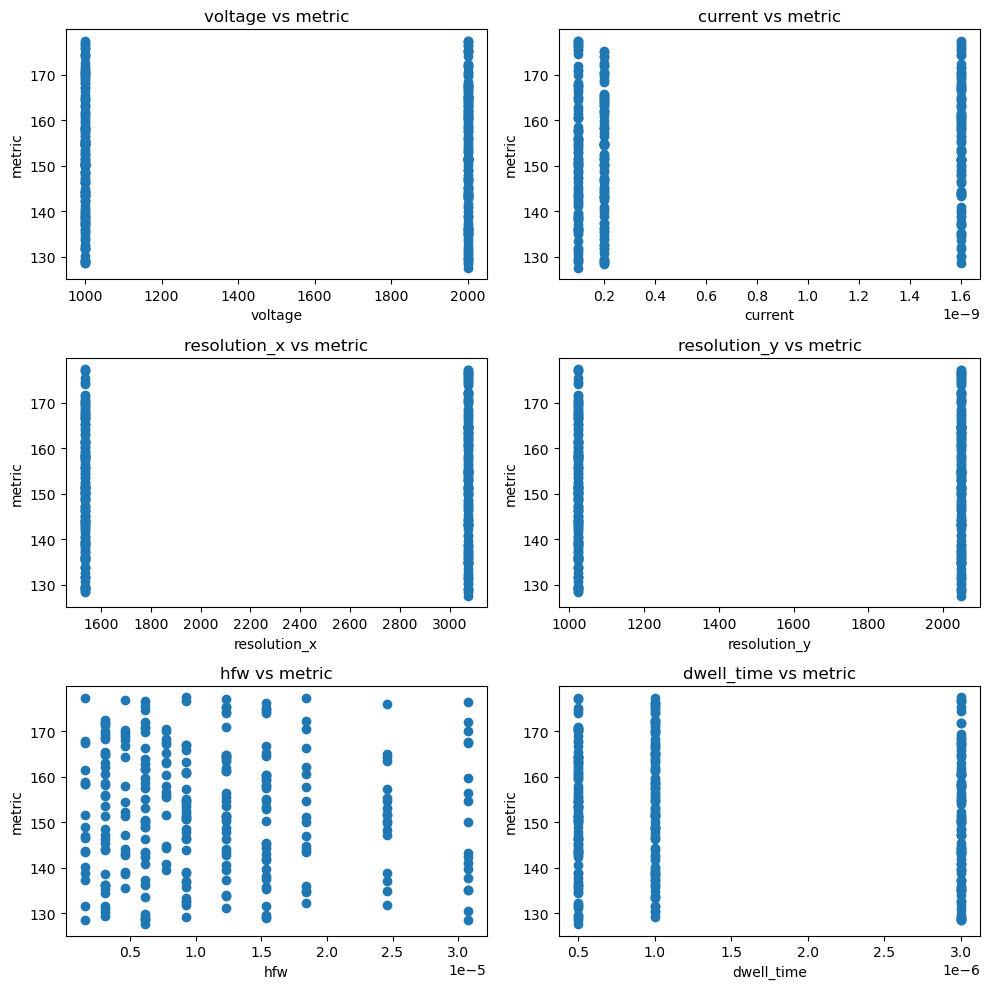

In [13]:
# plot metrics
df = pd.read_csv(os.path.join(base_path, "parameters_metrics.csv"))
# display(df)


# drop rows with no images
df = df[df["n_images"] > 0]

df = df.sort_values(by="metric", ascending=False)

# display(df)

fig, ax = plt.subplots(3, 2, figsize=(10, 10))

# plot each column against the metric, except the path and idx column
for i, col in enumerate(df.columns):
    if col not in ["path", "idx", "n_images","metric"]:
        ax[i//2, i%2].scatter(df[col], df["metric"])

        # add title and axis labels
        ax[i//2, i%2].set_title(f"{col} vs metric")
        ax[i//2, i%2].set_xlabel(col)
        ax[i//2, i%2].set_ylabel("metric")

plt.tight_layout()
plt.show()

